In [21]:
# 1. Loading the excel with survey response
# In this analysis, we will focus on analyzing these survey responses with NLP methods.

#### Importing modules
# for basic dataframe and data arrya functions
import pandas as pd
import numpy as np

# for text pre-processing and model development
import wordcloud  # library to generate wordcloud
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA, TruncatedSVD
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import wordnet, stopwords
from textblob import TextBlob

# for plotting and visualization
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline
import seaborn as sns

# for exception handling
import warnings
import re  # library for regular expression

from pprint import pprint

warnings.simplefilter("ignore", DeprecationWarning)

# Read datasets/papers.csv into papers
response = pd.read_csv(
    r'C:\Users\eskaa\OneDrive - Northern Kentucky University\02 RA - Spring 2021\692 Research Work\Data\HealthCarePrivacyPapers.csv', encoding='latin1')
print(response.head())


                                               Title Month  Year  \
0  An integrated framework for privacy protection...   May  2021   
1  hOCBS: A privacy-preserving blockchain framewo...   May  2021   
2  An End-to-End Authentication Scheme for Health...   Mar  2021   
3  Blockchain-as-a-Utility for Next-Generation He...   Mar  2021   
4  Findings From a Process Evaluation of an Indig...   Mar  2021   

                                              Author  
0                                                NaN  
1                                                NaN  
2                                     Nashwan, Shadi  
3  Almagrabi, Alaa Omran; Ali, Rashid; Alghazzawi...  
4  Firestone, Michelle; Syrette, Jessica; Brant, ...  


In [22]:
def annotate_plot(frame, plot_col, label_col, **kwargs):
    """
    Annotate the plot of a given DataFrame using one of its columns

    Should be called right after a DataFrame or series plot method,
    before telling matplotlib to show the plot.

    Parameters
    ----------
    frame : pandas.DataFrame

    plot_col : str
        The string identifying the column of frame that was plotted

    label_col : str
        The string identifying the column of frame to be used as label

    kwargs:
        Other key-word args that should be passed to plt.annotate

    Returns
    -------
    None

    Notes
    -----
    After calling this function you should call plt.show() to get the
    results. This function only adds the annotations, it doesn't show
    them.
    """

    for label, x, y in zip(frame[label_col], frame.index, frame[plot_col]):
        plt.annotate(label, xy=(x, y), **kwargs)

Year
2016     39
2017     52
2018     50
2019     79
2020    114
2021     27
dtype: int64


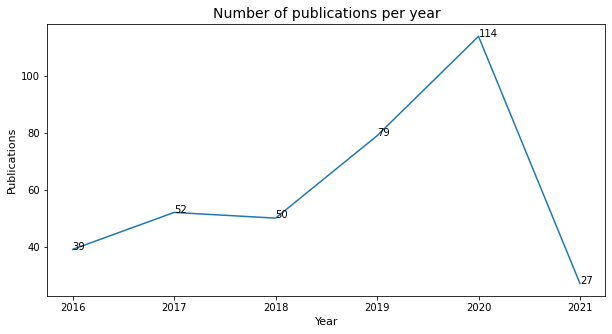

In [23]:
# 3a. Plotting how the opioid research has evolved over time
# A bar plot visualizing the number of publications per year is plotted below
# For this purpose, first the papers are grouped by year and its size is determined
groups = response[response['Year']>2015].groupby('Year')
counts = groups.size()
print(counts)

#x_ticks = papers.groupby('Year').groups.keys()
plt.figure(figsize=(10,5))
ax = counts.plot(kind='line')

for i, j in counts.items():
    ax.annotate(str(j), xy=(i,j))

plt.xlabel('Year', fontsize=11)
plt.ylabel('Publications', fontsize=11)
plt.xticks([2016,2017,2018,2019,2020,2021])
plt.title('Number of publications per year', fontsize=14)
plt.show()

In [24]:
# 3b. Text Pre-processing
special_stopwords = ['privacy','healthcare','secure','base','security','research','system','use','application','data','study','review','method','analysis','consumer','care','network','thing','wban','wbans','wlan','wpan','wsns','xbee','zigbee','wmsn','vwsn','uavs','tossim','roni','rout','pslp','pfps','nrfl','nidps','mqtt','itrust','ieath','ieee','hibe','hhdssc','ehealth','ehealthcare','ehrs','eids','ediscovery','eacbm','ecdsa']
my_stopwords = nltk.corpus.stopwords.words('english')
my_stopwords = my_stopwords + special_stopwords

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Snowball Stemming
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
# performs text conversion to lowercase, POS tagging & filter and Lemmatization
def clean_response(text, bigrams=False):
    text = text.lower() # lower case conversion
    text = re.sub('['+my_punctuation + ']+', ' ', text) # strip punctuation
    text = re.sub('\s+', ' ', text) #remove double spacing
    text = re.sub('([0-9]+)', '', text) # remove numbers
    text_token_list = [word for word in w_tokenizer.tokenize(text) if word not in my_stopwords] # remove stopwords

    #text_token_list = [word_rooter(word) if '#' not in word else word
                        #for word in text_token_list] # apply word rooter
    if bigrams:
        text_token_list = text_token_list+[text_token_list[i]+'_'+text_token_list[i+1]
                                            for i in range(len(text_token_list)-1)]
    return [token for token in text_token_list if len(token) > 3]

response['Title_processed'] = response.Title.apply(clean_response)

# Master function to POS tagging
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) or tag_dict.get(tag, wordnet.ADJ)

# Master function to Lemmatization and Stemming
def lemmatize_text(text):
    lemmatized_text = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in text]
    return lemmatized_text

response['Title_lemmatized'] = response.Title_processed.apply(lemmatize_text)

# Master Function for Extracion of Nouns
def extract_nouns(tokens):
    #tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    length = len(tagged) - 1
    noun_list = list()
    noun_list = [item[0] for item in tagged if item[1][0] == 'N']
    return ' '.join(noun_list)

response['Title_nouns'] = response.Title_lemmatized.apply(extract_nouns)
    
response.head(10)

,Title,Month,Year,Author,Title_processed,Title_lemmatized,Title_nouns
0,An integrated framework for privacy protection...,May,2021,NaN,"[integrated, framework, protection, applied, s...","[integrate, framework, protection, apply, smart]",integrate framework protection
1,hOCBS: A privacy-preserving blockchain framewo...,May,2021,NaN,"[hocbs, preserving, blockchain, framework, lev...","[hocbs, preserve, blockchain, framework, lever...",hocbs preserve blockchain framework leverage c...
2,An End-to-End Authentication Scheme for Health...,Mar,2021,"Nashwan, Shadi","[authentication, scheme, systems, using]","[authentication, scheme, system, use]",authentication scheme system use
3,Blockchain-as-a-Utility for Next-Generation He...,Mar,2021,"Almagrabi, Alaa Omran; Ali, Rashid; Alghazzawi...","[blockchain, utility, next, generation, intern...","[blockchain, utility, next, generation, intern...",blockchain utility generation thing
4,Findings From a Process Evaluation of an Indig...,Mar,2021,"Firestone, Michelle; Syrette, Jessica; Brant, ...","[findings, process, evaluation, indigenous, ho...","[finding, process, evaluation, indigenous, hol...",process evaluation housing support health case...
5,Secrecy-ensured NOMA-based cooperative D2D-aid...,Mar,2021,Rajesh Gupta; Sudeep Tanwar; Neeraj Kumar,"[secrecy, ensured, noma, based, cooperative, a...","[secrecy, ensure, noma, base, cooperative, aid...",base aid compute imperfect
6,Security model for protecting intellectual pro...,Mar,2021,Debasis Gountia; Sudip Roy,"[model, protecting, intellectual, property, st...","[model, protect, intellectual, property, state...",model property state biochip
7,A Bluetooth-Based Architecture for Contact Tra...,Jan,2021,Piergiuseppe Di Marco; Pangun Park; Marco Prat...,"[bluetooth, based, architecture, contact, trac...","[bluetooth, base, architecture, contact, trace...",architecture contact trace facility
8,Blockchain-based security & privacy for biomed...,Jan,2021,NaN,"[blockchain, based, biomedical, information, e...","[blockchain, base, biomedical, information, ex...",blockchain base information exchange system
9,Elliptic Curve Cryptography based authenticati...,Jan,2021,K. Sowjanya; Mou Dasgupta; Sangram Ray,"[elliptic, curve, cryptography, based, authent...","[elliptic, curve, cryptography, base, authenti...",curve cryptography base authentication scheme ...


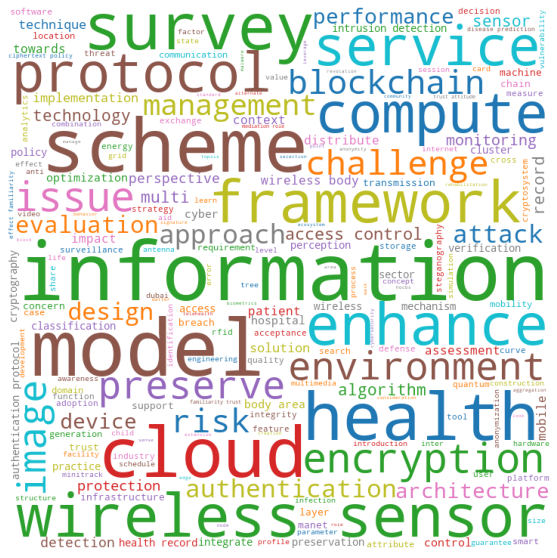

In [25]:
# 3c. Stop Word Filtering and Word Cloud Generation
long_string = " ".join(map(str, response['Title_nouns']))
stopwords = my_stopwords + list(STOPWORDS)
#stopwords = list(STOPWORDS)

# 3d. Generate and visualize a word cloud
wordcloud = wordcloud.WordCloud(stopwords=stopwords, width=720, height=720,background_color="white", colormap="tab10").generate(long_string)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.imshow(wordcloud)
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

In [26]:
# 4.  Prepare the text for LDA (latent Dirichlet allocation) analysis
# For LDA to work, documents need to be converted to simple vector representation. This will be used by LDA to determine the topics.
# So, we will convert a list of titles into a list of vectors, all with length equal to the vocabulary.
# Each entry of a 'document vector' will correspond with the number of times a word occurred in the document.
# Finally, the 10 most common words are plotted based on the outcome of this operation.
# As a check, these words should also occur in the word cloud.

# Helper function

def plot_n_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))
    
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    plt.figure(figsize=(15,10))
    ax = plt.bar(x_pos, counts, align='center')
    
    for p in ax:
        plt.text(p.get_x() + p.get_width()*offset['center'], 1.01*(p.get_height()),
                '{}'.format(p.get_height()), ha=ha['center'], va='bottom')
    
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('20 most common words')
    plt.show()

C:\Users\eskaa\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


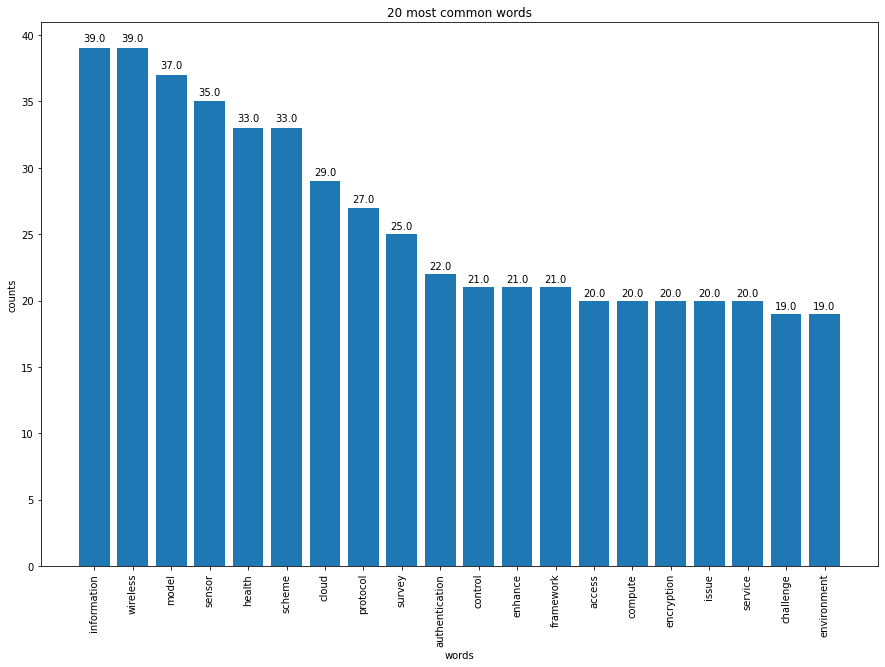

In [27]:
# 4a. Visualise the 30 most common words

vectorizer = CountVectorizer(stop_words=stopwords)
vectorized_data = vectorizer.fit_transform(response['Title_nouns'])
plot_n_most_common_words(vectorized_data, vectorizer)

In [36]:
# 4b. Materialize the sparse data
data_dense = vectorized_data.todense()

# 4b. Compute Sparsity = Percentage of Non-Zero cells
print("Sparsity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsity:  0.6475893842060866 %


In [37]:
# 4c. Analysing trends with LDA
# This step would enable us to identify the number of unique topics using the perplexity factor.

# Helper function

def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(", ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Tweak the two parameters below (Can use any int values)
number_topics = 20
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit_transform(vectorized_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)


Topics found via LDA:

Topic #0:
control, access, health, preserve, cloud, architecture, management, mechanism, monitoring, record

Topic #1:
risk, protection, sensor, wireless, facility, value, community, access, architecture, surveillance

Topic #2:
body, area, wireless, attack, scheme, transmission, mechanism, industry, defense, optimization

Topic #3:
monitoring, context, cloud, distribute, algorithm, compute, guarantee, platform, blockchains, identity

Topic #4:
model, policy, encryption, access, practice, detection, ciphertext, attribute, control, context

Topic #5:
survey, issue, authentication, scheme, analytics, performance, solution, session, enhance, biometrics

Topic #6:
blockchain, implementation, solution, design, information, framework, chain, communication, mobility, exchange

Topic #7:
trust, perspective, risk, perception, role, issue, effect, impact, familiarity, attitude

Topic #8:
service, verification, design, card, device, access, development, scheme, case, threat

In [38]:
# 4d. Diagnosing the Model Performance through Log Likelihood and Perplpexity factor

# Log Likelyhood: Higher the better
#Log Likelihood is the logarithmic measure of probability in topic-keyword matrix (prob that the keyword belongs to a certain topic)
print("Log Likelihood: ", lda.score(vectorized_data))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(vectorized_data))

# See model parameters
print(lda.get_params())

Log Likelihood:  -14396.939194329945
Perplexity:  1245.382039614663
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [39]:
# 4e. Finding the Best LDA Model through GridSearchCV
# Define Search Param
search_params = {'n_components': [5,10,15,20,25,30]}

# Init the Model
search_lda = LDA()

# Init Grid Search Class
model = GridSearchCV(search_lda, param_grid=search_params)

# Do the Grid Search
model.fit(vectorized_data)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(vectorized_data))

Best Model's Params:  {'n_components': 5}
Best Log Likelihood Score:  -4193.741187890703
Model Perplexity:  744.0555677139411


In [40]:
model.cv_results_

{'mean_fit_time': array([0.32856135, 0.28544593, 0.27627144, 0.28515935, 0.27371674,
        0.27787423]),
 'std_fit_time': array([0.01266709, 0.0019379 , 0.00701878, 0.01535817, 0.00468245,
        0.00248191]),
 'mean_score_time': array([0.01098013, 0.00997329, 0.00957427, 0.01016626, 0.00976558,
        0.01036134]),
 'std_score_time': array([1.89545020e-05, 6.30826420e-04, 4.88499796e-04, 3.99920274e-04,
        4.05427787e-04, 1.00366913e-03]),
 'param_n_components': masked_array(data=[5, 10, 15, 20, 25, 30],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_components': 5},
  {'n_components': 10},
  {'n_components': 15},
  {'n_components': 20},
  {'n_components': 25},
  {'n_components': 30}],
 'split0_test_score': array([-4673.17520624, -5819.43618769, -6756.30846777, -7693.05931026,
        -8326.64110982, -9134.71614904]),
 'split1_test_score': array([-3967.3453673 , -4961.84271182, -5864.03754341,

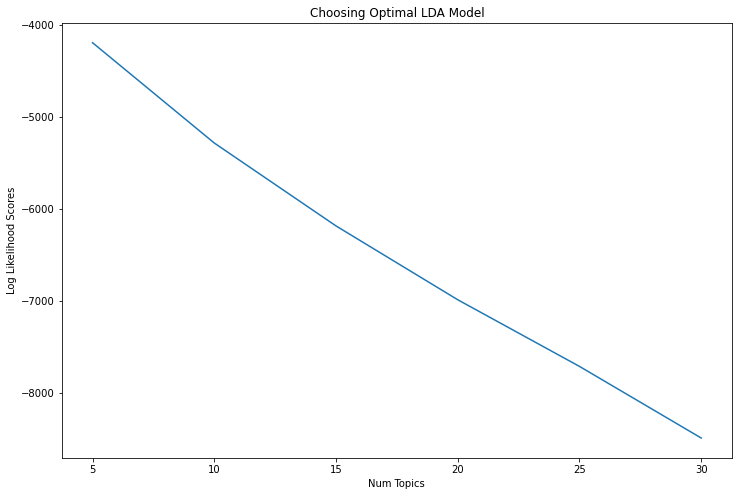

In [41]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5,10,15,20,25,30]
log_likelihood = [round(gscore) for gscore in model.cv_results_['mean_test_score']]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelihood)
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelihood Scores")
plt.show()

In [42]:
#Topics found for the best fit LDA model
print("Topics found for our Best Fit LDA Model:")
print_topics(best_lda_model, vectorizer, 10)

Topics found for our Best Fit LDA Model:

Topic #0:
model, information, risk, performance, multi, detection, assessment, encryption, compute, algorithm

Topic #1:
health, control, access, record, monitoring, preserve, challenge, management, framework, mobile

Topic #2:
survey, information, solution, enhance, protocol, challenge, technology, wireless, sensor, approach

Topic #3:
wireless, sensor, scheme, protocol, authentication, cloud, blockchain, framework, body, enhance

Topic #4:
environment, issue, attack, architecture, wireless, service, survey, compute, scheme, technique


In [43]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(vectorized_data)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Title" + str(i) for i in range(len(response))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

def round_two_decimals(val):
    return np.round(val, 2)

# Apply Style
df_formatted = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold).format("{:.2f}").format({'dominant_topic': "{:.0f}"})
df_formatted

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Title0,0.05,0.80,0.05,0.05,0.05,1
Title1,0.02,0.02,0.02,0.91,0.02,3
Title2,0.07,0.07,0.07,0.73,0.07,3
Title3,0.05,0.05,0.05,0.80,0.05,3
Title4,0.02,0.93,0.02,0.02,0.02,1
Title5,0.05,0.05,0.05,0.80,0.05,3
Title6,0.84,0.04,0.04,0.04,0.04,0
Title7,0.04,0.04,0.04,0.04,0.84,4
Title8,0.05,0.05,0.05,0.80,0.05,3
Title9,0.03,0.03,0.03,0.69,0.21,3


In [44]:
# review Topic Distribution across documents - same as the bar plot shown above
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="No. of Research Titles")
df_topic_distribution.columns = ['Topic No.', 'No. of Research Titles']
df_topic_distribution

,Topic No.,No. of Research Titles
0,1,110
1,3,107
2,0,87
3,4,85
4,2,78


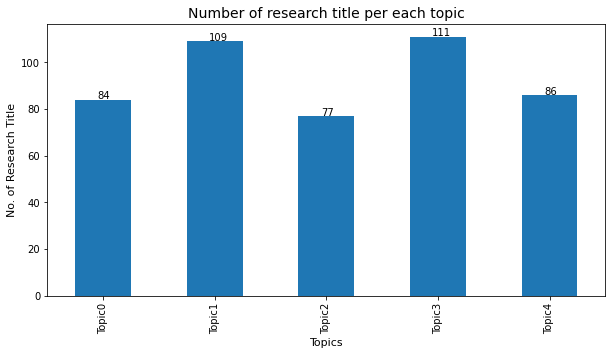

In [45]:
docsPerTopic = best_lda_model.transform(vectorized_data)
docsPerTopic = pd.DataFrame(docsPerTopic, columns=["Topic"+str(i) for i in range(best_lda_model.n_components)])
most_likely_topics = docsPerTopic.idxmax(axis=1)
counts = most_likely_topics.groupby(most_likely_topics).count()

plt.figure(figsize=(10,5))
ax=counts.plot(kind='bar')

for p, label in zip(ax.patches, counts.values):
    ax.annotate(label, (p.get_x()+0.2, p.get_height()+0.3))

plt.xlabel('Topics', fontsize=11)
plt.ylabel('No. of Research Title', fontsize=11)
plt.title('Number of research title per each topic', fontsize=14)
plt.show()

In [46]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
#df_topic_keywords.head()

#Export to csv
df_topic_keywords.to_csv('TopicKeywordMatrix.csv', index=True)

In [47]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda, n_words=10):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,model,information,risk,performance,multi,detection,assessment,encryption,compute,algorithm
Topic 1,health,control,access,record,monitoring,preserve,challenge,management,framework,mobile
Topic 2,survey,information,solution,enhance,protocol,challenge,technology,wireless,sensor,approach
Topic 3,wireless,sensor,scheme,protocol,authentication,cloud,blockchain,framework,body,enhance
Topic 4,environment,issue,attack,architecture,wireless,service,survey,compute,scheme,technique


In [48]:
# Visualize the LDA Model that is selected as the best fit - (T-stochastic Neighbor Estimate)

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, vectorized_data, vectorizer, mds='tsne')
panel

C:\Users\eskaa\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      150.222153  -72.269554       1        1  23.763984
1       51.163364 -159.968018       2        1  23.630696
0      -73.144554   21.523815       3        1  19.006982
4      -66.410133 -110.606438       4        1  18.037701
2       54.417324   12.443444       5        1  15.560637, topic_info=           Term       Freq      Total Category  logprob  loglift
284      health  25.000000  25.000000  Default  30.0000  30.0000
589      survey  19.000000  19.000000  Default  29.0000  29.0000
142     control  16.000000  16.000000  Default  28.0000  28.0000
2        access  16.000000  16.000000  Default  27.0000  27.0000
497      record  15.000000  15.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
364  management   2.321282  12.813471   Topic5  -4.9083   0.1520
376   mechanism   1.696304   6.048281   Topic5  -5.2220   0.5891
540      sector   1.606019   5.976920   Topic5  -5.2767   0.5463
139     context   1.605808   7.532068   Topic5  -5.2768   0.3149
562       smart   1.604490   4.510377   Topic5  -5.2776   0.8269

[299 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2         2  0.935544       access
11        4  0.891903  aggregation
13        3  0.513282    algorithm
13        4  0.410626    algorithm
15        5  0.905692    alternate
...     ...       ...          ...
639       5  0.336629        video
645       5  0.905692         walk
655       1  0.626755     wireless
655       4  0.197923     wireless
655       5  0.164936     wireless

[383 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 5, 3])